# import das bibliotecas

In [45]:


%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy import signal
from glob import glob
from scipy import stats


rcParams['figure.figsize'] = [16., 5.]

### Filtros

In [2]:
# definições de filtros

def butter_bandpass(data, lowcut, highcut, fs=200, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data)

def butter_lowpass(data, lowcut, fs=200, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='lowpass')
    return signal.filtfilt(b, a, data)

def butter_highpass(data, highcut, fs=200, order=4):
    nyq = fs * 0.5
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='highpass')
    return signal.filtfilt(b, a, data)

def butter_notch(data, cutoff, var=1, fs=200, order=4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    b, a = signal.iirfilter(order, [low, high], btype='bandstop', ftype="butter")
    return signal.filtfilt(b, a, data)

### Carregando Dados

In [3]:
def plotData(dirs):
    data = np.load("datasets/topicos_cc/"+dirs)
    data = np.transpose(data, (0, 2, 1))
    print(data.shape)
    data_filtered = butter_notch(data, 60)
    data_filtered = butter_highpass(data_filtered, 5)
    data_filtered = butter_lowpass(data_filtered, 50)
    for i in range(data_filtered.shape[1]):
        plt.plot(data_filtered[0,i,:])
    plt.suptitle(dirs)
    plt.show()


In [4]:
def loadSujeito(dirs):
    data = np.load("datasets/topicos_cc/"+dirs)
    data = np.transpose(data, (0, 2, 1))
    data_filtered = butter_notch(data, 60)
    data_filtered = butter_highpass(data_filtered, 5)
    data_filtered = butter_lowpass(data_filtered, 50)
    
    return data_filtered

In [5]:
dirs = [ i.split("/")[-1] for i in glob('datasets/topicos_cc/p1*')]
data = []
for d in dirs:
    data.append(loadSujeito(d))

In [6]:
np.array(data).shape

(3, 8, 4, 1600)

### Visualizando

(8, 4, 1600)


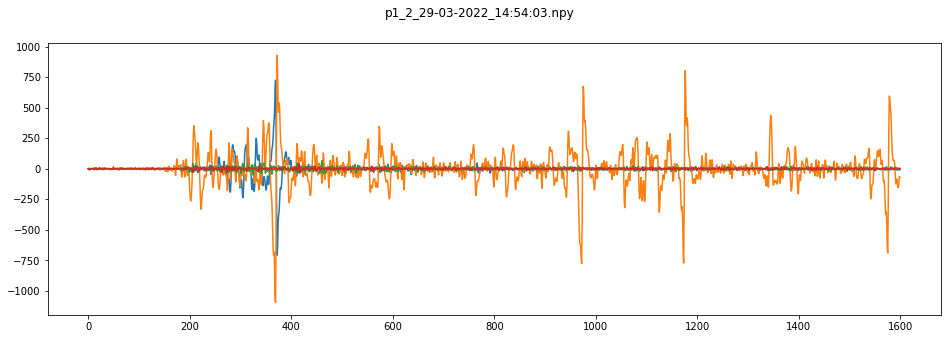

(8, 4, 1600)


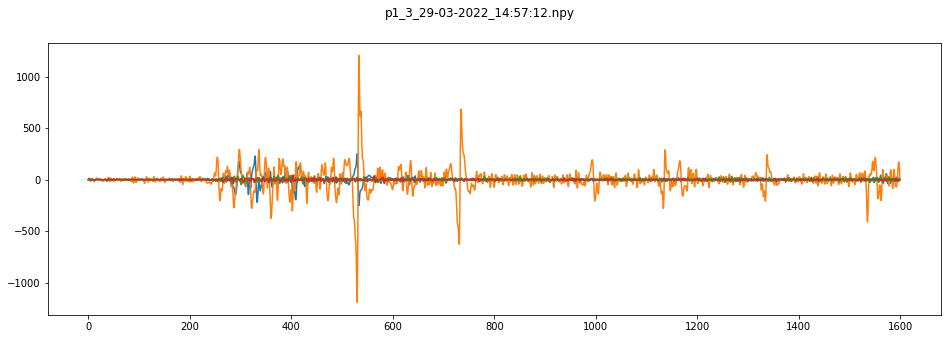

(8, 4, 1600)


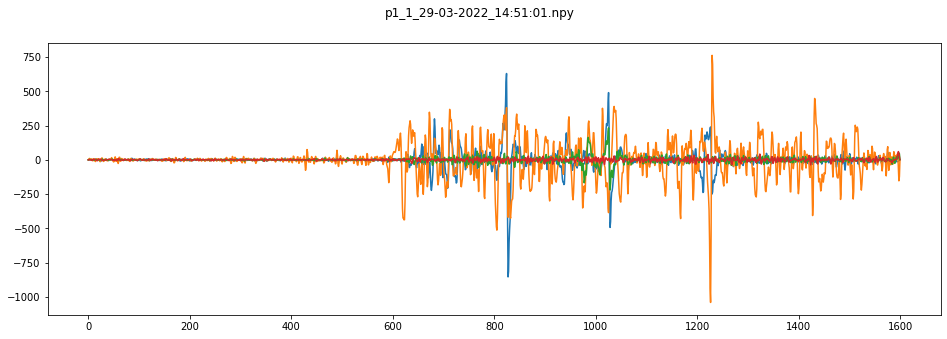

In [7]:
for d in dirs:
    plotData(d)

# Concatenando Trials x Movimentos

In [8]:
import numpy as np

#X = data.reshape(24, 4, 1600)
X = np.concatenate((data), axis=0)
X.shape


(24, 4, 1600)

## Segmentação dos dados

In [9]:
from scipy.signal import stft

step = 58
segment = 128
data = X.reshape(24, 4, 1600)
print('', data.shape)

n_win = int((data.shape[-1] - segment) / step) + 1
ids = np.arange(n_win) * step

# Janelas do dado no dominio do tempo
chunks_time = np.array([data[:,:,k:(k + segment)] for k in ids]).transpose(1, 2, 0, 3)

# Janelas do dado no domínio da frequência
_, _, chunks_freq = stft(data, fs=200, nperseg=128, noverlap=64)
chunks_freq = np.swapaxes(chunks_freq, 2, 3)

print('Formato (shape) dos dados depois da divisão de janelas')
print(f'Dominio do tempo: {chunks_time.shape} - (classes+ensaios, canais, janelas, linhas)')
print(f'Dominio da frequência:  {chunks_freq.shape} - (classes+ensaios, canais, janelas, linhas)')

#sstft 200 128 64 .... 25 26 janelas
#Ajustar o step no dominio da frequência


#step = 470
#segment = 1024
#_, _, chunks_freq = stft(data, fs=4000, nperseg=1024, noverlap=512)



 (24, 4, 1600)
Formato (shape) dos dados depois da divisão de janelas
Dominio do tempo: (24, 4, 26, 128) - (classes+ensaios, canais, janelas, linhas)
Dominio da frequência:  (24, 4, 26, 65) - (classes+ensaios, canais, janelas, linhas)


## Extração e seleção de características

In [10]:
def getZC(data, th):
    tamanho = len(data)
    somatoria = 0
    
    for i in range(tamanho-1):
        resultado = (data[i] * data[i+1] )
        resultado2 = np.abs(data[i] - data[i+1])
        if(resultado < 0 ) and (resultado2 > th):
            somatoria += 1
        
    return somatoria

def fj(i, sampleRate, tamanho):
    return i * sampleRate / (2 * tamanho)

def getFMN(data):
    tamanho = len(data)
    somatoria = 0
    sumPSD = np.sum(PSD(data))
    for i in range(tamanho):
        somatoria += (fj(i, 41, tamanho) * PSD(data[i]) ) / sumPSD
        
    return somatoria



In [11]:
from math import prod

# funções auxiliares
def PSD(w):
    ''' definição da função PSD para o sinal no domínio da frequência '''
    return np.abs(w) ** 2

def wamp(x, th):
    res = np.abs(np.diff(x))
    return np.sum(res >= th, axis=-1)

def wl(x):
    res = np.abs(np.diff(x))
    return np.sum(res, axis=-1)

def var(x):
    return np.sum(x ** 2, axis=-1) / (np.prod(x.shape[:-1]) - 1)

def rms(x):
    return np.sqrt(np.sum(np.abs(x) ** 2, axis=-1) / (np.prod(x.shape[:-1]) - 1))

def fmd(w):
    return np.sum(PSD(w), axis=-1) / 2

def mmdf(w):
    return np.sum(np.abs(w), axis=-1) / 2

def zc(data,threshold):
    f =[]
    x,y,z = data.shape[:3]
    for xx in range(x):
        fx = []
        for yy in range(y):
            fy = []
            for zz in range(z):
                fy.append( getZC(data[xx][yy][zz], threshold ) )
            fx.append(fy)
        f.append(fx)
    return np.array(f)

def fmn(data):
    f =[]
    x,y,z = data.shape[:3]
    for xx in range(x):
        fx = []
        for yy in range(y):
            fy = []
            for zz in range(z):
                
                fy.append( getFMN(data[xx][yy][zz]) )
                
            fx.append(fy)
        f.append(fx)
    return np.array(f)

def A(w):
    return np.abs(w)

def getMMNF(data):
    tamanho = len(data)
    somatoria = 0
    
    sumA = np.sum(A(data))
    
    for i in range(tamanho):
        somatoria += (fj(i, 200, tamanho) * A(data[i]) ) / sumA 
        
    return somatoria

def mmnf(data):
    f =[]
    x,y,z = data.shape[:3]
    for xx in range(x):
        fx = []
        for yy in range(y):
            fy = []
            for zz in range(z):
                
                fy.append( getMMNF(data[xx][yy][zz]) )
                
            fx.append(fy)
        f.append(fx)
    return np.array(f)

def logD(data):
    from math import e
    N = np.prod(data.shape)
    
    return e ** ( np.sum(np.log10( np.abs(data) ), axis=-1) ) / N

## Implementação do vetor

In [46]:
th = np.median(chunks_time)

In [43]:
final_data = list()
final_data.append(var(chunks_time))
final_data.append(rms(chunks_time))
final_data.append(wamp(chunks_time, th))
final_data.append(wl(chunks_time))
final_data.append(zc(chunks_time,0))
final_data.append(logD(chunks_time))

final_data.append(fmd(chunks_freq))
final_data.append(mmdf(chunks_freq))
final_data.append(fmn(chunks_freq))
final_data.append(mmnf(chunks_freq))



final = np.array(final_data)
final.shape

(10, 24, 4, 26)

## PCA


In [47]:
data = final.transpose(0, 1, 3, 2)
sh = data.shape

X = data.reshape(sh[0], int(sh[1]/3), 3 * sh[2], sh[3])

print(X.shape)
for f in X:
    print(f.shape)

(10, 8, 78, 4)
(8, 78, 4)
(8, 78, 4)
(8, 78, 4)
(8, 78, 4)
(8, 78, 4)
(8, 78, 4)
(8, 78, 4)
(8, 78, 4)
(8, 78, 4)
(8, 78, 4)


In [48]:
from sklearn.decomposition import PCA

In [16]:
pca = PCA(n_components=2)

features = list()
for f in X:
    classes = list()
    for c in f:
        C_pca = pca.fit_transform(c)
        classes.append(C_pca)
    features.append(classes)

X_pca = np.array(features)

In [17]:
X_pca.shape

(10, 8, 78, 2)

## Visualização

In [18]:
def plot_features(features, features_names, classes_names, ch_1, ch_2):
    
    movs = np.arange(len(classes_names))
    markers = ["o", "v", "^", "P", "*", "x", "X", "2", "3", "1"]
    for f, feature in enumerate(features):
        
        for mov, marker in zip(movs, markers):
            # argumentos: classes, amostras, canal
            plt.scatter(feature[mov, :, ch_1],
                        feature[mov, :, ch_2], marker=marker)

        plt.legend((classes_names), scatterpoints=1, loc='best',
                   ncol=3, fontsize=8)
        
        plt.title(features_names[f])
        plt.xlabel('CH{}'.format(ch_1))
        plt.ylabel('CH{}'.format(ch_2))
        plt.show()


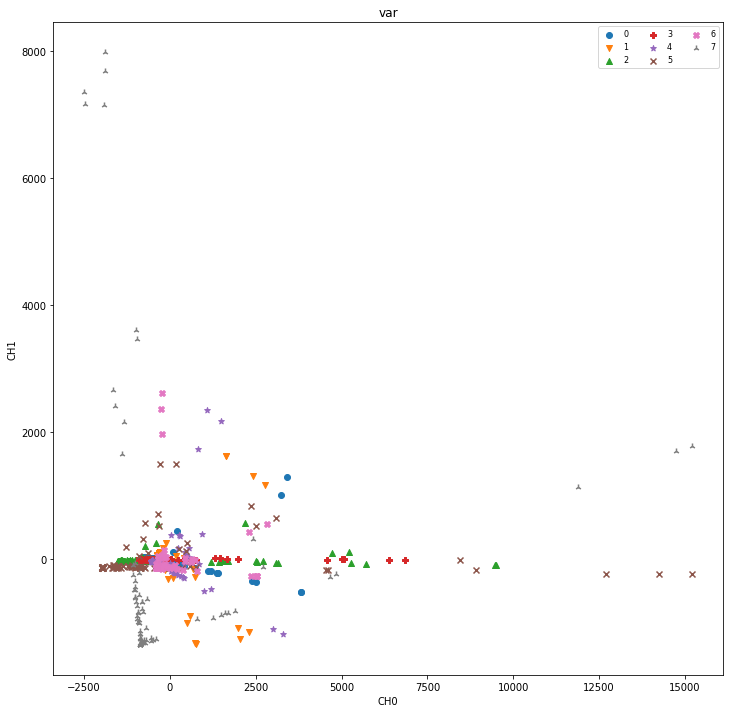

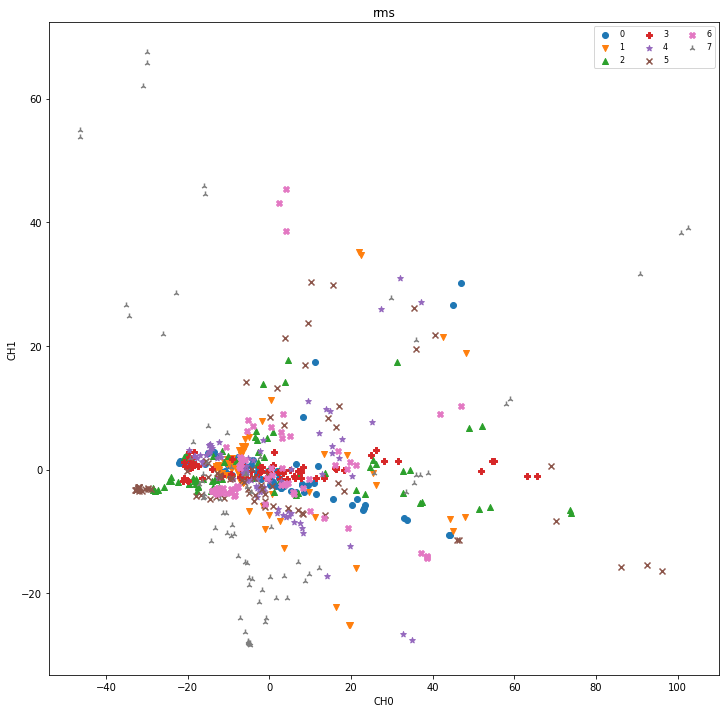

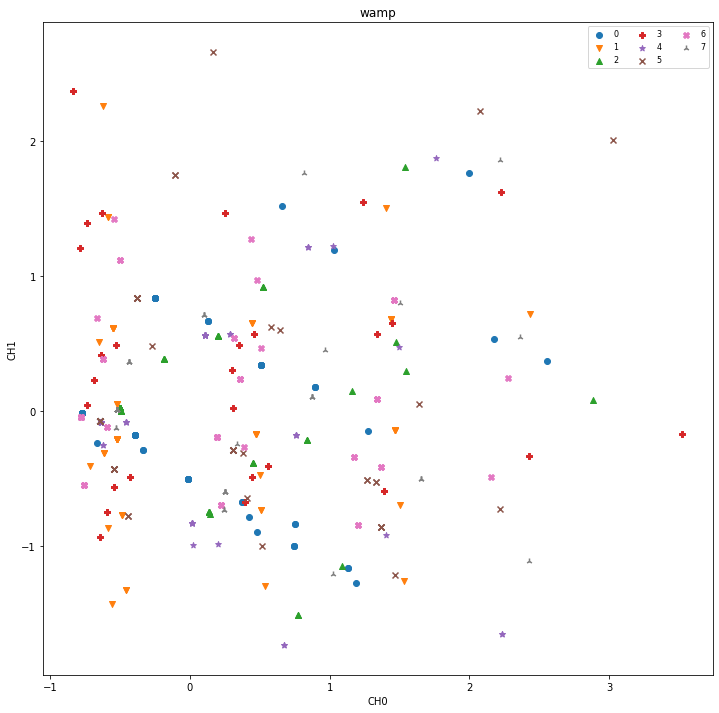

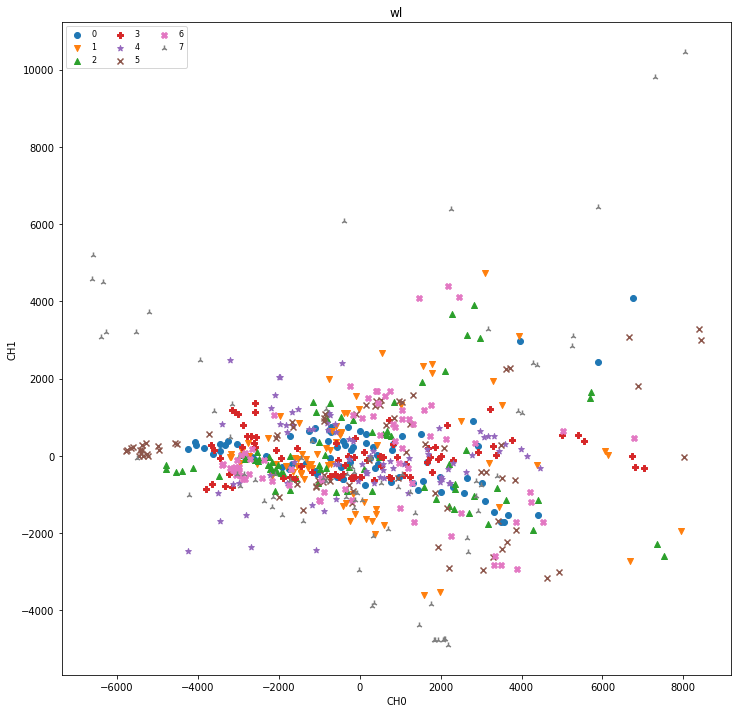

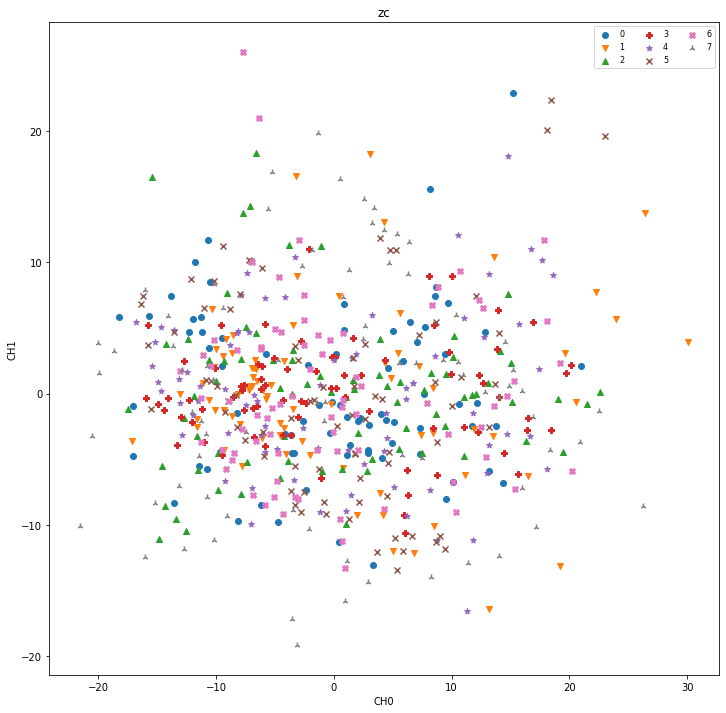

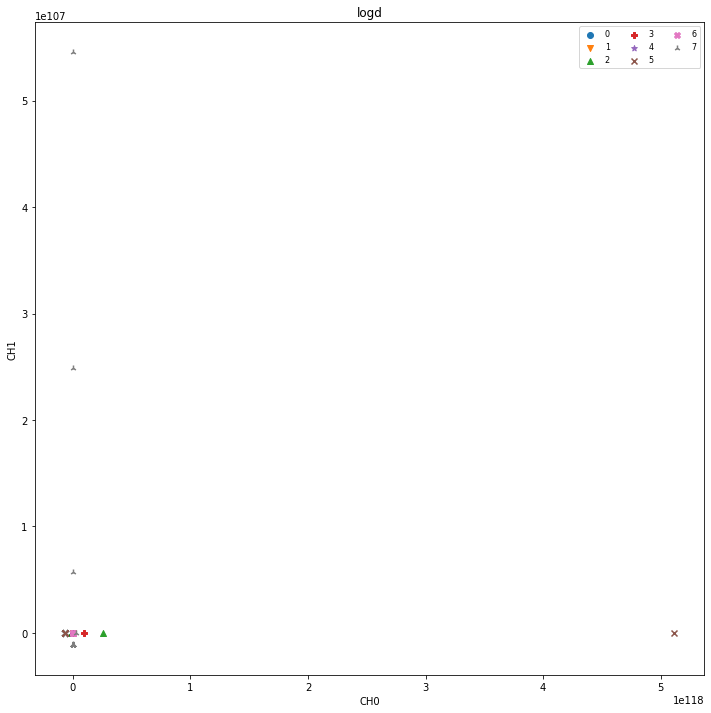

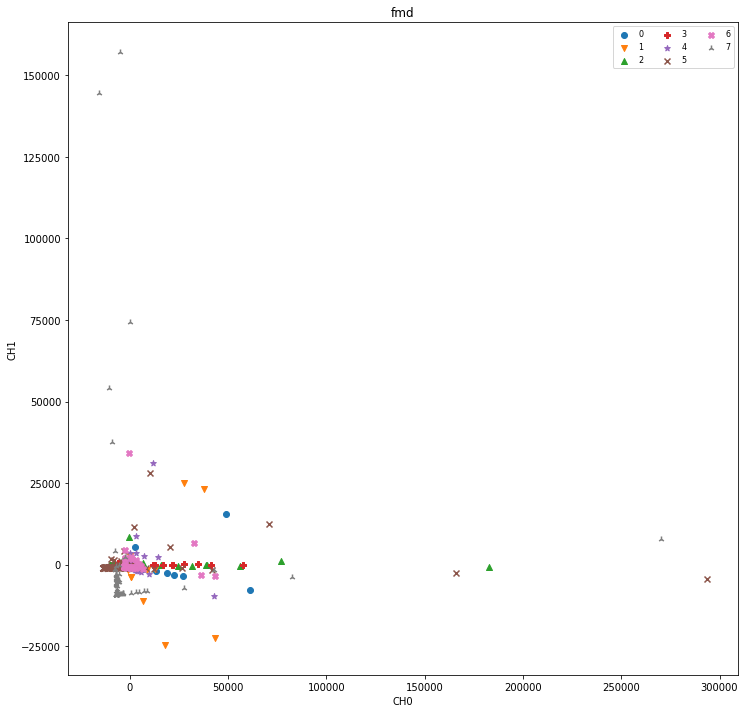

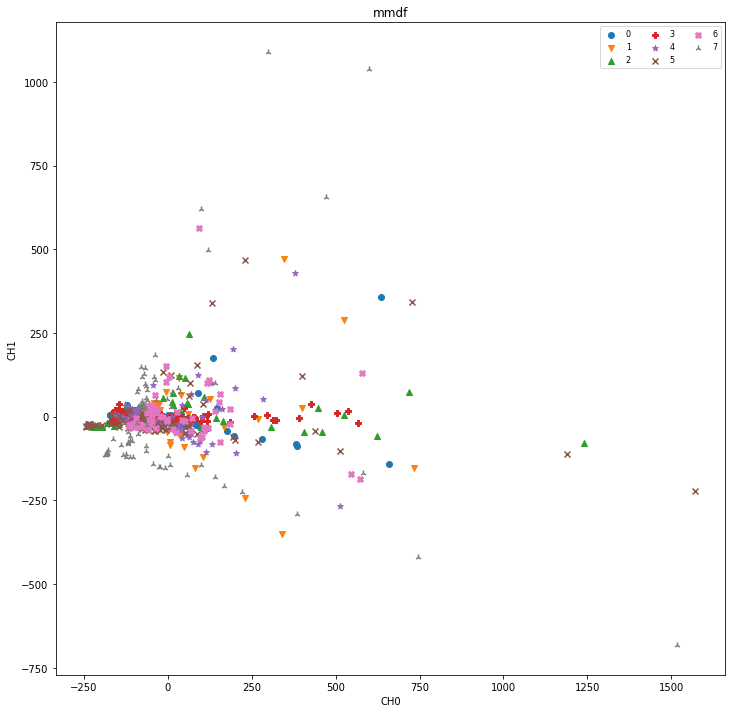

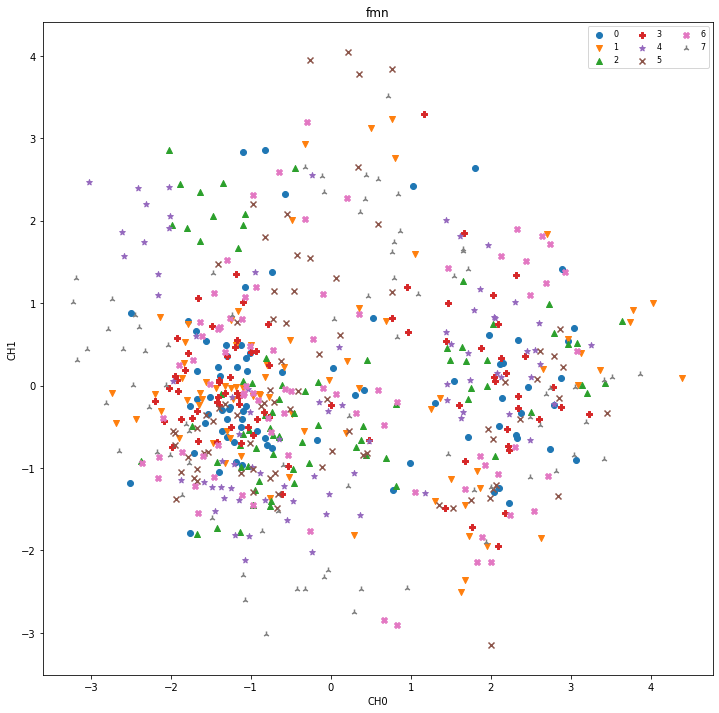

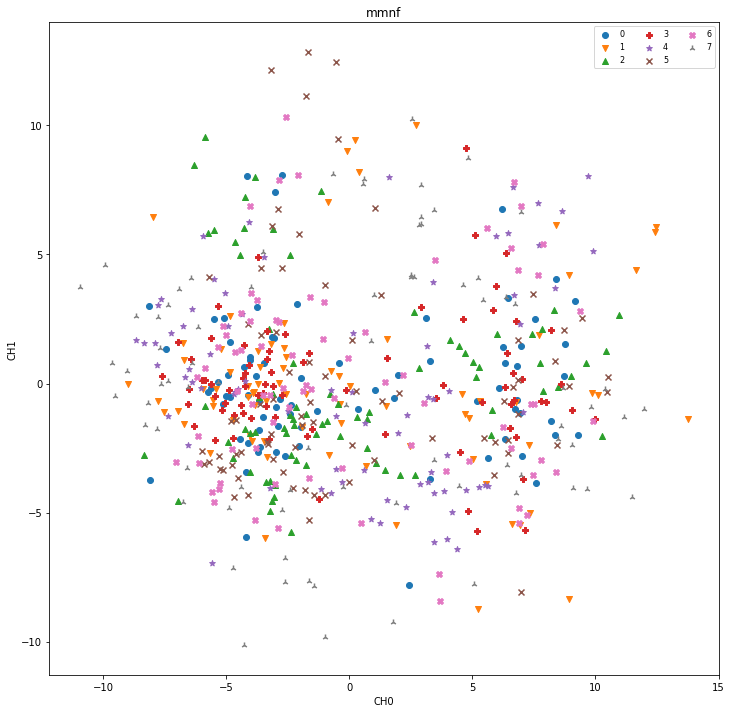

In [19]:


import matplotlib.pyplot as plt
from matplotlib import rcParams

plt.rcParams["figure.figsize"] = (12, 12)

features_name = ('var', 'rms', 'wamp', 'wl', 'zc','logd', 'fmd', 'mmdf', 'fmn', 'mmnf')
classes = [str(item) for item in list(range(8))]
plot_features(X_pca, features_name, classes, 0, 1)


## Transpose para Selecionar Feature

In [49]:
final.shape
# 24*26 ,9, 4
# 24*26 , 10, 4

(10, 24, 4, 26)

In [51]:
data = final.transpose(1, 3, 2, 0)
X = data.reshape(data.shape[0]*data.shape[1], data.shape[2]*data.shape[3])
X.shape

(624, 40)

In [52]:
# y = np.array(list(range(1, 9)) * int(X.shape[0] / 8)) # Antigo

y = [ [str(i)] * int(X.shape[0] / 8 ) for i in range(8)]
y = np.array(y).flatten()
y.shape

(624,)

## Seleção de características

## Variance Threshold


In [53]:
# teste

data_t = final.transpose(1, 3, 2, 0)
# X_t = data.reshape(24*26, 9, 4)
X_t = data.reshape(24*26, 10, 4)

data_t = X_t.transpose(2, 0, 1)
data_t.shape


(4, 624, 10)

In [55]:
from sklearn.feature_selection import VarianceThreshold
canais = list()

for c in data_t:
    sel = VarianceThreshold(threshold=(.1))
    vt = sel.fit_transform(c)
    canais.append(vt)


### RFE (Por causa do Kernel Linear não iremos utilizar)

In [ ]:
# from sklearn.feature_selection import RFE
# from sklearn.svm import SVC
# estimator = SVC(kernel="linear")
# selector = RFE(estimator, n_features_to_select=5, step=1)
# selector = selector.fit(X, y)
# s = selector.fit_transform(X, y)

### GenericUnivariateSelect

In [24]:
X.shape, y.shape

((624, 40), (624,))

In [56]:
from sklearn.feature_selection import GenericUnivariateSelect, chi2
transformer = GenericUnivariateSelect(chi2, mode='k_best', param=20)
X_new = transformer.fit_transform(X, y)
X_new.shape

(624, 20)

In [59]:
from sklearn.feature_selection import SelectKBest
X_new = SelectKBest(k=10).fit_transform(X, y)

In [64]:
X.shape, X_new.shape

((624, 40), (624, 10))

## Normalização

In [57]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_norm = scaler.fit_transform(X)

X_new_norm = scaler.fit_transform(X_new)

## SVM

In [39]:
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn import metrics

def do_svm(X,y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    
    clf = SVC()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    
    acc = metrics.accuracy_score(y_test, y_pred)
    
    return acc

do_svm(X,y), do_svm(X_norm,y)

(0.10897435897435898, 0.36538461538461536)

# Combinations

In [ ]:
# Acrecentar a LogDetector
# Add o tunning.ipynb
        # - HiperParametrizar o SVM
        

In [44]:
from itertools import combinations

best_acc = 0
best_comb = 0
for comb in range(1,12):
    for res in combinations(range(9),comb):
        acc = do_svm(X_norm.take(res, axis=1), y)

        if acc > best_acc:
            best_acc = acc
            best_comb = res

print(f"Melhor Acurácia: {best_acc}, Melhor Combinação: {best_comb}")

features_name = ('var', 'rms', 'wamp', 'wl', 'zc','logd', 'fmd', 'mmdf', 'fmn', 'mmnf')
for i in best_comb:
    print(f" {i} --- {features_name[i]}")


Melhor Acurácia: 0.28846153846153844, Melhor Combinação: (3, 5, 8)
 3 --- wl
 5 --- logd
 8 --- fmn


In [41]:
from itertools import combinations

best_acc = 0
best_comb = 0
for comb in range(1,12):
    for res in combinations(range(9),comb):
        acc = do_svm(X.take(res, axis=1), y)

        if acc > best_acc:
            best_acc = acc
            best_comb = res

print(f"Melhor Acurácia: {best_acc}, Melhor Combinação: {best_comb}")

features_name = ('var', 'rms', 'wamp', 'wl', 'zc','logd', 'fmd', 'mmdf', 'fmn', 'mmnf')
for i in best_comb:
    print(f" {i} --- {features_name[i]}")


Melhor Acurácia: 0.3141025641025641, Melhor Combinação: (0, 2, 3, 4, 7, 8)
 0 --- var
 2 --- wamp
 3 --- wl
 4 --- zc
 7 --- mmdf
 8 --- fmn


In [ ]:
from itertools import combinations

best_acc = 0
best_comb = 0
best_k = 0
for comb in range(1,12):
    for res in combinations(range(9),comb):
        for ks in range(1,41):
            X_new = SelectKBest(k=ks).fit_transform(X, y)
            acc = do_svm(X_new_norm.take(res, axis=1), y)

            if acc > best_acc:
                best_acc = acc
                best_comb = res
                best_k = ks

print(f"Melhor Acurácia: {best_acc}, Melhor Combinação: {best_comb}, Melhor K: {best_k}")


